In [1]:
using DrWatson, Revise;
@quickactivate "haram";

In [2]:
using DrWatson
using main
using DynamicPPL, Bijectors
using Zygote
using LinearAlgebra, Plots, Pipe
using CSV, DataFrames
using Turing
using Libtask: TArray
using Libtask
using ForwardDiff
using ProgressMeter
using ProgressLogging
using Pipe

ProgressMeter.ijulia_behavior(:clear);
gr(fmt=:png, levels=7)

┌ Info: Precompiling main [d4387e3f-b08f-4148-9d80-1476cd5e70f5]
└ @ Base loading.jl:1664


Plots.GRBackend()

In [3]:
Dists = (;
    Δ=Uniform(-1178.939, 1179.939),
    β=Uniform(-0.6, 0.60),
    μ=Uniform(-39, 30),
    τ=InverseGamma(1.0, 1.0),
    σ2=InverseGamma(1.0, 2e-7)
)
K = keys(Dists)
B = map(x -> bijector(x), Dists)
Binv = map(x -> inverse(x), B)

fmap(x, B) = map((f, x) -> f(x), B, x)
v2n(V::Vector{T}, S::NTuple) where {T<:Real} = Zygote.@ignore NamedTuple{S}(V)
v2n(V::Vector{T}, S::Vector{Symbol}) where {T<:Real} = NamedTuple{(; S)}(V)

df = CSV.File(datadir("q0957usno.csv")) |> DataFrame
first(df, 5)

Row,time,lca,sea,lcb,seb
,Float64,Float64,Float64,Float64,Float64
1,4554.71,2.671,0.004,2.419,0.004
2,4555.77,2.659,0.004,2.412,0.004
3,4561.72,2.665,0.004,2.417,0.004
4,4570.67,2.669,0.004,2.413,0.004
5,4584.68,2.664,0.004,2.378,0.004


In [4]:
@model function π_delay(df::DataFrame, ::Type{T}=Float64) where {T}
    Δ ~ Dists.Δ |> transformed
    β ~ Dists.β |> transformed
    μ ~ Dists.μ |> transformed
    τ ~ Dists.τ |> transformed
    σ2 ~ Dists.σ2 |> transformed
    Δ0, β0, μ0, τ0, σ20 = fmap([Δ, β, μ, τ, σ2], Binv)

    n, m = size(df)
    ω = τ0 * σ20 / 2

    T2n = [df.time; df.time .- Δ0]
    ord = sortperm(T2n)
    ord_inv = invperm(ord)

    se = [df.sea; df.seb][ord]
    x = [df.lca; df.lcb][ord]

    tΔ = T2n[ord]
    a = [0; exp.(-diff(tΔ) ./ τ0)]

    Ω = fill(T(se[1]^2 / (se[1]^2 + ω)), 2n)
    s = fill(T((se[1]^2 + ω) / se[1]), 2n)

    for i in 2:2n
        Ω[i] = (se[i]^2) / (
            (se[i]^2) + (a[i-1]^2 * se[i-1]^2 * (1 - Ω[i])) + (ω * (1 - a[i]^2))
        )
        s[i] = (se[i]^2) / (Ω[i]^2)
    end

    x = [0; x[1:end-1]]
    df.lca ~ MvNormal((a.*x)[ord_inv][1:n] .+ μ0, s[ord_inv][1:n])
    df.lcb ~ MvNormal((a.*x)[ord_inv][n+1:2n] .+ μ0 .+ β0, s[ord_inv][n+1:2n])
end

π_delay (generic function with 3 methods)

In [5]:
function p1(df::DataFrame, z::Vector{T}) where {T<:Float64}
    K = keys(Dists)
    K2 = K[1:end.!=1]
    ℓ(x) = logjoint(π_delay(df) | v2n([z...], K2), (; Δ=x))
    U(x) = isfinite(ℓ(x)) ? -ℓ(x) : 1e100
    dU(x) = ForwardDiff.derivative(U, x)
    f(x) = max(exp(-U(x)), 1e-100)
    g(x) = ForwardDiff.derivative(f, x)
    return main.Model(ξ=Dists, d=1, f=f, g=g, U=U, dU=dU)
end

function p2(df::DataFrame, z::Vector{T}) where {T<:Float64}
    K = keys(Dists)
    K2 = K[1:end.!=2]
    ℓ(x) = logjoint(π_delay(df) | v2n([z...], K2), (; β=x))
    U(x) = isfinite(ℓ(x)) ? -ℓ(x) : 1e100
    dU(x) = ForwardDiff.derivative(U, x)
    f(x) = max(exp(-U(x)), 1e-100)
    g(x) = ForwardDiff.derivative(f, x)
    return main.Model(ξ=Dists, d=1, f=f, g=g, U=U, dU=dU)
end


function p3(df::DataFrame, z::Vector{T}) where {T<:Float64}
    K = keys(Dists)
    K1 = K[1:end.∈Ref(1:2)]
    K2 = K[1:end.∉Ref(1:2)]
    ℓ(x) = logjoint(π_delay(df) | v2n(z, K1), v2n([x...], K2))
    U(x) = isfinite(ℓ(x)) ? -ℓ(x) : 1e100
    dU(x) = ForwardDiff.gradient(U, x)
    f(x) = max(exp(-U(x)), 1e-100)
    g(x) = ForwardDiff.gradient(f, x)
    return main.Model(ξ=Dists, d=length(Dists) - 2, f=f, g=g, U=U, dU=dU)
end

p3 (generic function with 1 method)

In [27]:
function gibbs_step3(df, S, z)
    S1, S2, S3 = S
    z1, z2, z3 = z

    m1 = p1(df, [z2.q; z3.q])
    z1 = RefreshState(z1.q, z1, S1, m1)
    z1 = (; z1..., p=only(z1.p), m=1e5)
    n1, a1 = OneStep(z1, S1, m1)
    b1 = rand() < a1
    z1 = b1 ? n1 : z1

    m2 = p2(df, [z1.q; z3.q])
    z2 = RefreshState(z2.q, z2, S2, m2)
    z2 = (; z2..., p=only(z2.p), m=1e5)
    n2, a2 = OneStep(z2, S2, m2)
    b2 = rand() < a2
    z2 = b2 ? n2 : z2

    m3 = p3(df, [z1.q; z2.q])
    z3 = RefreshState(z3.q, z3, S3, m3)
    n3, a3 = OneStep(z3, S3, m3)
    b3 = rand() < a3
    z3 = b3 ? n3 : z3
    return (z1, z2, z3, b1 && b2 && b3)
end



function gibbs_sample3(df, S; n=1000, n_burn=1, init=B[1](400.0), m=ones(5))
    S1, S2, S3 = S
    q1, q2, q3 = init, randn(), randn(3)

    z1 = InitializeState(q1, S1, p1(df, [q2; q3]))
    z1 = (; z1..., q=only(z1.q), p=only(z1.p), m=m[1])

    z2 = InitializeState(q2, S2, p2(df, [q1; q3]))
    z2 = (; z2..., q=only(z2.q), p=only(z2.p), m=m[2])

    z3 = InitializeState(q3, S3, p3(df, [q1; q2]))
    z3 = (; z3..., q=z3.q, p=z3.p, m=m[3:end])

    N = Int(n + n_burn)
    samples = repeat([z1.q; z2.q; z3.q...]', N + 1)
    accepts = fill(false, N + 1)

    p = Progress(N)
    generate_showvalues(x) = () -> [("Gibbs", x)]

    @progress for i ∈ 1:N
        z1, z2, z3, α_MH = gibbs_step3(df, S, (z1, z2, z3))
        samples[i+1, :] = [z1.q; z2.q; z3.q...]
        accepts[i+1] = α_MH

        next!(p; showvalues=generate_showvalues(mean(accepts[1:i+1])))
    end

    samples = samples[Int(n_burn):end, :]
    accepts = accepts[Int(n_burn):end]
    @info "Acceptance Ratio" ratio = round(mean(accepts); digits=4)
    return (samples, accepts)
end

gibbs_sample3 (generic function with 1 method)

In [53]:
s, a = gibbs_sample3(
    df,
    (
        main.HaRAM(ϵ=2e-2, L=10, γ=0.9),
        main.HaRAM(ϵ=2e-1, L=5, γ=0.1),
        main.HaRAM(ϵ=2e-5, L=3, γ=0.1),
    ),
    n=5000,
    m = [5e5; 1e2; ones(3)]
)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:24
  Gibbs:  0.11995201919232307
┌ Info: Acceptance Ratio
│   ratio = 0.12
└ @ Main In[27]:59


([0.7052926699665553 3.0255391876941222 … -1.1241657253826647 -1.4491050705352706; 0.7052926699665553 3.0251380133282533 … -1.1241188442133259 -1.4490012907713616; … ; 0.6387812833613966 2.812120222582688 … -1.1548000814298098 -1.4511560949186737; 0.6387812833613966 2.8149377855864612 … -1.1547482871992925 -1.4510718187219955], Bool[0, 0, 1, 0, 1, 0, 1, 1, 0, 0  …  0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

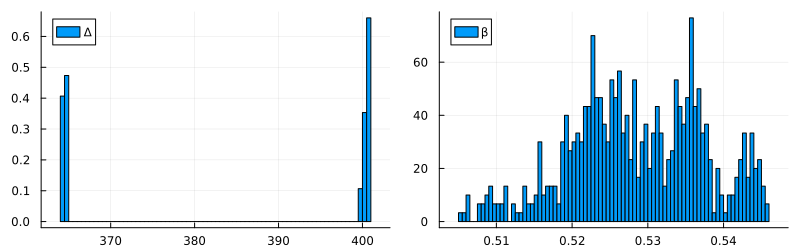

In [54]:
θ = fmap(eachcol(s[a, :]), Binv)
# θ = fmap(eachcol(s[:, :]), Binv)
hist = plot(
    histogram(θ[1], bins=100, label="Δ", normalize=true), 
    histogram(θ[2], bins=100, label="β", normalize=true), 
    layout=(1, 2), size=(800, 250)
)
hist

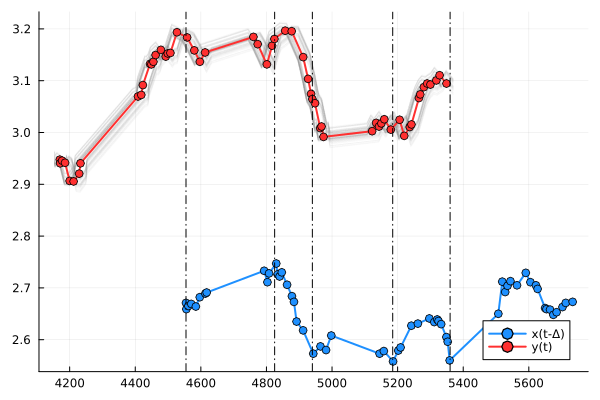

In [55]:
plt = plot(df.time, df.lca, marker=:o, label="", lw=2, la=0, ma=0)

for i in sample(eachindex(θ[1]), 100)
    plt = plot(plt, df.time .- θ[1][i], df.lcb .+ θ[2][i], label="", lw=1, la=0.05, c=:grey)
end

plt = plot(plt, df.time, df.lca, marker=:o, label="x(t-Δ)", lw=2, c=:dodgerblue)
plt = plot(plt, df.time .- mean(θ[1]), df.lcb .+ mean(θ[2]), marker=:o, label="y(t)", c=:firebrick1, lw=2)
vline!([minimum(df.time), 4825, 4940, 5185, 5360], label="", legend=:bottomright, ls=:dashdot, c=:black)

In [ ]:
# savefig(hist, plotsdir("astro/hist.pdf"))
# savefig(hist, plotsdir("astro/hist.svg"))
# savefig(plt, plotsdir("astro/match.pdf"))
# savefig(plt, plotsdir("astro/match.svg"))